In [107]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

In [108]:
DATA_DIR = '../input'
n_splits=5

In [109]:
files = pathlib.Path(DATA_DIR).iterdir()
list(files)

[PosixPath('../input/air_store_info.csv'),
 PosixPath('../input/date_info.csv'),
 PosixPath('../input/store_id_relation.csv'),
 PosixPath('../input/.gitkeep'),
 PosixPath('../input/hpg_reserve.csv'),
 PosixPath('../input/air_reserve.csv'),
 PosixPath('../input/air_visit_data.csv'),
 PosixPath('../input/sample_submission.csv'),
 PosixPath('../input/hpg_store_info.csv')]

In [110]:
air_res = pd.read_csv('../input/air_reserve.csv')
df_id = pd.read_csv('../input/store_id_relation.csv')
air_store = pd.read_csv('../input/air_store_info.csv')
hpg_store = pd.read_csv('../input/hpg_store_info.csv')
air_visit = pd.read_csv('../input/air_visit_data.csv')

## air_id, hpg_idは全て一意で，hpgが4690件，airが829件あり，1対1に対応しているのは150件(df_idの)

In [111]:
df_id['air_store_id'].nunique(), df_id['hpg_store_id'].nunique()

(150, 150)

In [112]:
(df_id['air_store_id'].value_counts() == 1).sum(), (df_id['hpg_store_id'].value_counts() == 1).sum()

(150, 150)

In [113]:
air_store.shape, air_store['air_store_id'].nunique()

((829, 5), 829)

In [114]:
hpg_store.shape, hpg_store['hpg_store_id'].nunique()

((4690, 5), 4690)

In [115]:
air_visit.shape, air_store.shape

((252108, 3), (829, 5))

In [116]:
df_air = pd.merge(air_visit, air_store, on='air_store_id')

assert df_air.shape == (252108, 7), 'Fuckin shape'

## EDA

### 来客数の時系列の推移

Text(0.5, 1.0, 'sum of visitors groupby date')

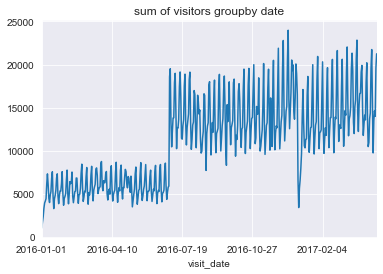

In [120]:
# 2016年の6月ごろに合計の来客数が激増している
# 2017年の1月(2016年12月？)ごろに，訪問者数が激減している
df_air.groupby('visit_date')['visitors'].sum().plot()
plt.title('sum of visitors groupby date')

Text(0.5, 1.0, 'mean of visitors groupby date')

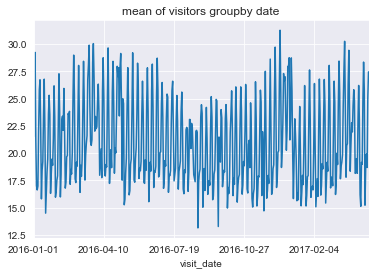

In [123]:
# 来客数の平均
# 平均では先ほどのような大きな差がないため，おそらく店舗数が激増していると思われる
df_air.groupby('visit_date')['visitors'].mean().plot()
plt.title('mean of visitors groupby date')

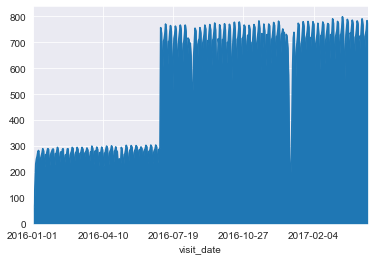

In [128]:
# つまりこういうことで，観測している店舗の数がある時を境に激増・激減している
# この増減部分は，機械学習が丸めてくれるか，特徴に何かを追加するもしくは学習データから省いて，対処するかはモデリングの際に要検討
df_air.groupby('visit_date')['air_store_id'].nunique().plot.area()

### レストランごとにどれだけの日数のデータがあるか
- 少ない店舗は合計20日分ほどしかデータがないものがあり，ノイズになる恐れもある

Text(0, 0.5, 'number of data')

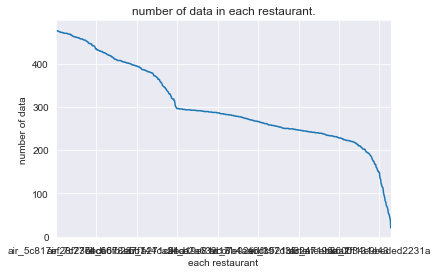

In [126]:
df_air['air_store_id'].value_counts().plot()
plt.title('number of data in each restaurant.')
plt.xlabel('each restaurant')
plt.ylabel('number of data')

### 店舗ごとの来客数をみる
- 1日あたりの来客数は最低の店舗で1日1人から，最大で115人までで，平均的には21人
- 店のidの特徴や，もしくは立地的な特徴が重要になる可能性が高い

(1.1875, 115.47058823529412, 21.20388676889276)

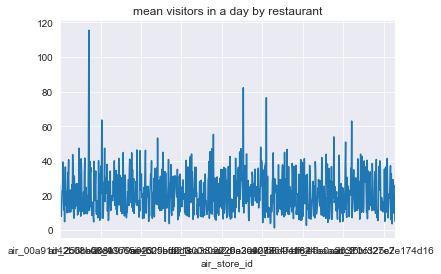

In [138]:
mean_visitors = df_air.groupby('air_store_id')['visitors'].mean()
mean_visitors.plot()
plt.title('mean visitors in a day by restaurant')

# 1日平均客数の最大・最小は1.19と115
mean_visitors.min(), mean_visitors.max(), mean_visitors.mean()

[]

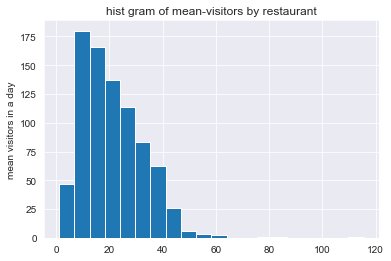

In [144]:
mean_visitors.hist(bins=20)
plt.title('hist gram of mean-visitors by restaurant')
plt.ylabel('mean visitors in a day')
plt.plot()

### 予約客のデータ(air_res)の詳細を見ていく

In [146]:
air_res.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [147]:
air_res['date'] = air_res['visit_datetime'].apply(lambda x: x.split(' ')[0])

In [148]:
air_res.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01


Text(0.5, 1.0, 'sum of reserved visitors')

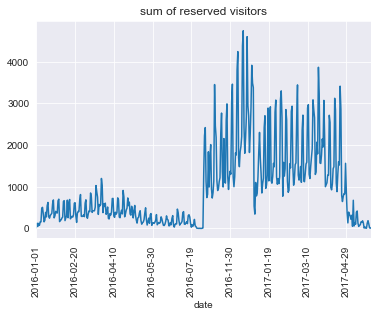

In [156]:
air_res.groupby('date')['reserve_visitors'].sum().plot()
plt.xticks(rotation=90)
plt.title('sum of reserved visitors')

Text(0.5, 1.0, 'mean of reserved visitors')

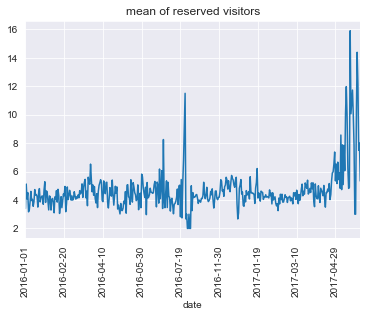

In [158]:
# 予約客は全体の客数平均21人に対して，4人程度なので最悪このデータはなくてもある程度の予測は可能だと思われる
air_res.groupby('date')['reserve_visitors'].mean().plot()
plt.xticks(rotation=90)
plt.title('mean of reserved visitors')

### restaurantのgenreを見ていく

In [160]:
# レストランのジャンル分けは以下の14種類
df_air['air_genre_name'].unique().tolist()

['Dining bar',
 'Izakaya',
 'Cafe/Sweets',
 'Bar/Cocktail',
 'Italian/French',
 'Okonomiyaki/Monja/Teppanyaki',
 'Other',
 'International cuisine',
 'Japanese food',
 'Yakiniku/Korean food',
 'Karaoke/Party',
 'Western food',
 'Creative cuisine',
 'Asian']

Text(0.5, 1.0, 'mean visitors by genre')

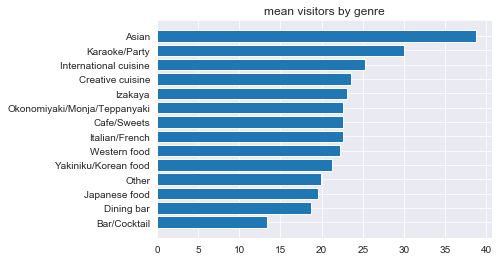

In [171]:
# バーなどは平均客数が少なく，アジア料理がダントツで多い(なんで？)
# ジャンルごとのtarget encodingが特徴量としてかなり効きそう
mean_visitors_by_genre = df_air.groupby('air_genre_name')['visitors'].mean().sort_values()
plt.barh(mean_visitors_by_genre.index, mean_visitors_by_genre)
plt.title('mean visitors by genre')

### 計算店舗の地理情報を見ていく

<BarContainer object of 9 artists>

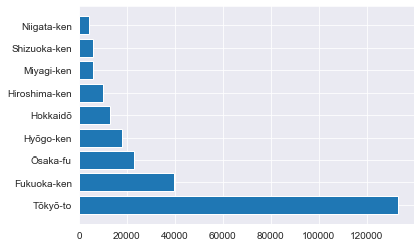

In [175]:
# 掲載店舗は都市部のみで，東京がほとんど
# 特徴量としては，東京以外の場合はそのまま都道府県の情報，東京はもう少し細分化して与えるといいかも？
df_air['air_prefecture'] = df_air['air_area_name'].apply(lambda x: x.split(' ')[0])
prefecture_cnt = df_air['air_prefecture'].value_counts()
plt.barh(prefecture_cnt.index, prefecture_cnt)

Text(0.5, 1.0, 'mean visitors in each prefecture')

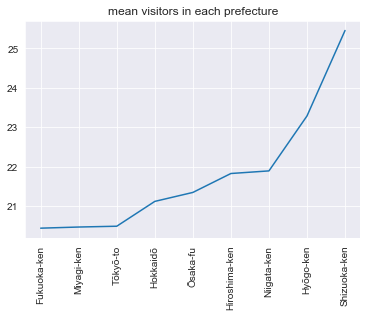

In [59]:
# 都道府県ごとの平均客数は大体20人で大差はない
mean_visitors_pref = df_air.groupby('air_prefecture')['visitors'].mean().sort_values()
plt.plot(mean_visitors_pref)
plt.xticks(rotation=90)
plt.title('mean visitors in each prefecture')

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 9 Text xticklabel objects>)

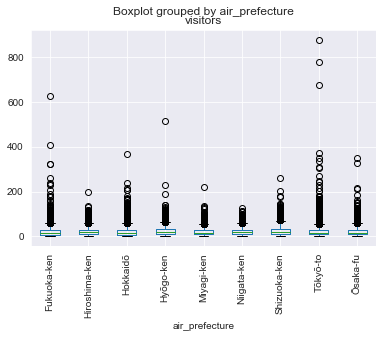

In [60]:
# 東京や福岡，大阪，兵庫など都会ほど忘年会などの影響のせいか，客数が200(平均は20程度)を超える日が多いことがわかる
df_air.boxplot(column=['visitors'], by='air_prefecture')
plt.xticks(rotation=90)

### 時期と客数

In [176]:
df_air['year'] = df_air['visit_date'].apply(lambda x: x.split('-')[0])
df_air['month'] = df_air['visit_date'].apply(lambda x: x.split('-')[1])
df_air['day'] = df_air['visit_date'].apply(lambda x: x.split('-')[2])

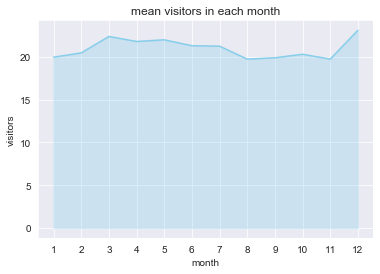

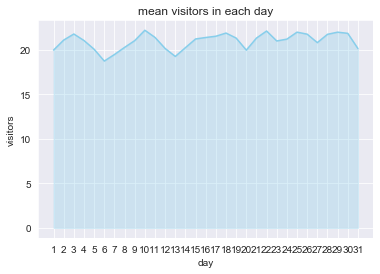

In [177]:
# 毎月の平均客数plot
# 夏の暑い時期に人が減少するっぽい？
# 12月に増加するのはおそらく忘年会やクリスマス？
# 3月の増加は送別会や卒業関連？
# 毎月末にはやや増加傾向？

for i in ['month', 'day']:
    y = df_air.groupby(i)['visitors'].mean()
    x = range(1, len(y)+1)

    plt.fill_between(x, y, color='skyblue', alpha=0.3)
    plt.plot(x, y, color='skyblue', alpha=1.0)
    plt.title(f'mean visitors in each {i}')
    plt.xlabel(i)
    plt.ylabel('visitors')
    plt.xticks(x)
    plt.show()

In [184]:
df_day = pd.read_csv('../input/date_info.csv')

In [185]:
df_day.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


### 休日情報も追加する

In [186]:
prev_len = len(df_air)
df_air = pd.merge(df_air, df_day, left_on='visit_date', right_on='calendar_date')

assert len(df_air) == prev_len, 'Fuckin shape'

In [187]:
df_air.isnull().sum()

air_store_id      0
visit_date        0
visitors          0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
air_prefecture    0
year              0
month             0
day               0
calendar_date     0
day_of_week       0
holiday_flg       0
dtype: int64

In [188]:
df_air['holiday_flg'].value_counts()  # 祝日は土日は含まない

0    239333
1     12775
Name: holiday_flg, dtype: int64

(array([0., 1., 2., 3., 4., 5., 6.]), <a list of 7 Text xticklabel objects>)

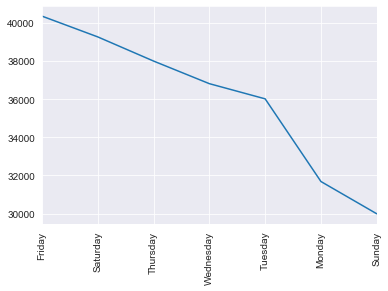

In [191]:
# 曜日よってデータ数がやや異なる(ほぼ影響はないと思うが)
df_air['day_of_week'].value_counts().plot()
plt.xticks(rotation=90)

[]

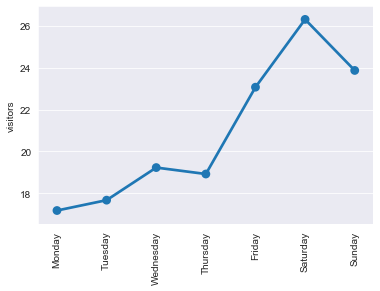

In [192]:
# 曜日ごとの平均客数
# 金曜土曜が多いのは想像通りだが，金曜よりも日曜の方が多い

y = df_air.groupby('day_of_week')['visitors'].mean()
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y = y[x]
sns.pointplot(x, y)
plt.xticks(rotation=90)
plt.plot()

## 評価指標に関する考察
評価指標はRMSLE(Root Mean Squared Logarithmic Error)

$$
    RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(p_i+1)-log(a_i+1))^2}
$$

- $ p_i $ がモデルの予測した来客数
- $ a_i $ が実際の来客数

### 一般によく用いられるRMSE(Root Mean Squared Error)と何が異なるのか
- 各要素の対数を取っている
- 以下のplotを見てわかる通り，
    - 予測が実際を下回る場合には，大きくペナルティがかかる．
    - 予測が実際を上回る場合には，あまり大きなペナルティとならない
    - つまり，予測を実際が上回った時に，仕入れの在庫が不足するなど問題が生じるため
    - 多少過剰に在庫を抱えるのは決して不利益に直結しない
    - また以下のplotより，同じ誤差でも，スケールが大きい方が，lossが小さく評価される

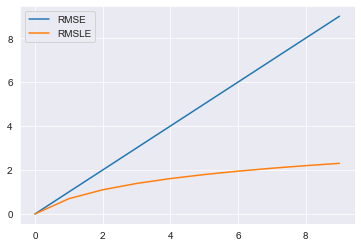

In [81]:
plt.plot(np.arange(10), label='RMSE')
plt.plot(np.log1p(np.arange(10)), label='RMSLE')
plt.legend()

In [82]:
from sklearn.metrics import mean_squared_error

In [94]:
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return np.sqrt(mean_squared_error(y_true, y_pred))


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    msle = mean_squared_error(np.log1p(y_true), np.log1p(y_pred))
    return np.sqrt(msle)

### RMSEでは大きく振れても小さく振れても，誤差は同じになるが，RMSLEでは小さく振れた場合により大きくペナルティを課すことがわかる

In [98]:
y_true = np.array([1000, 1000])
y_pred_lower = np.array([600, 600])
y_pred_higher = np.array([1400, 1400])

In [102]:
print(f'RMSLE: {rmse(y_true, y_pred_higher)}')
print(f'RMSLE: {rmse(y_true, y_pred_lower)}')

RMSLE: 400.0
RMSLE: 400.0


In [106]:
print(f'RMSLE: {rmsle(y_true, y_pred_higher)}')
print(f'RMSLE: {rmsle(y_true, y_pred_lower)}')

RMSLE: 1.9654988206395103
RMSLE: 2.8118454324413094


### RMSLEは誤差が同じなら，スケールが小さい方を優先的に学習させるように意図されている

In [105]:
y_true = np.array([1000, 1000])
y_pred = np.array([1400, 1400])
print(f'RMSLE: {rmsle(y_true, y_pred)}')

y_true = np.array([10000, 10000])
y_pred = np.array([10400, 10400])
print(f'RMSLE: {rmsle(y_true, y_pred)}')

RMSLE: 0.3361867670217862
RMSLE: 0.03921686737661645
